# Figures 7 & 7-1

Pairwise differences in neurophysiological differentiation among stimuli

In [1]:
from pathlib import Path

import pandas as pd
from IPython.display import Image
from tqdm.auto import tqdm

import analysis
from analysis import CONTINUOUS_NATURAL, prepare_data_for_r

In [2]:
OUTPUT_DIR = Path('figures')

## Set up R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(tidyverse)
library(broom)
library(ggplot2)
library(lme4)
library(multcomp)
library(emmeans)

theme_set(theme_minimal())

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: TH.data

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching package: ‘MASS’


R[write to console]: The following object is masked from ‘package:dp

## Load data

In [5]:
df = pd.read_parquet("results/main.parquet")

In [6]:
response = "log(normalized differentiation)"

In [7]:
# Compare continuous natural stimuli
df = df.loc[
    df['stimulus'].isin(CONTINUOUS_NATURAL),
]

In [8]:
df = prepare_data_for_r(df, response)

## Fit model

In [9]:
df.stimulus.unique()

array(['conspecifics', 'crickets (prey)', 'man writing', 'mousecam',
       'snake (predator)'], dtype=object)

In [10]:
formula = f"`{response}` ~ 1 + stimulus + (1 | session)"
reduced_formula = f"`{response}` ~ 1 + (1 | session)"
print(formula)
print(reduced_formula)

`log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
`log(normalized differentiation)` ~ 1 + (1 | session)


In [11]:
%%R -i df -i formula -i reduced_formula

# Order factors
df$stimulus = fct_relevel(
    df$stimulus,
    "snake (predator)",
    "mousecam", 
    "conspecifics", 
    "crickets (prey)", 
    "man writing"
)

# Estimate models
model = lmer(formula, data=df, REML=FALSE)
reduced_model = lmer(reduced_formula, data=df, REML=FALSE)

# Compare models
model_comparison = anova(model, reduced_model)
print(model_comparison)

/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2201: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  elif not timezones.tz_compare(tz, inferred_tz):
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2282: PytzUsageWarning: The zone attribute is specific to pytz's i

Data: df
Models:
reduced_model: `log(normalized differentiation)` ~ 1 + (1 | session)
model: `log(normalized differentiation)` ~ 1 + stimulus + (1 | session)
              Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)    
reduced_model  3 2926.0 2943.1 -1460.0   2920.0                             
model          7 2901.8 2941.7 -1443.9   2887.8 32.115      4  1.812e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Post hoc tests of pairwise differences in estimated marginal means among stimuli

In [12]:
%%R -o pairwise_differences -o confidence_intervals

# Estimate marginal means
posthoc = emmeans(model, list(pairwise ~ stimulus), adjust='tukey', alternative='two.sided')
confidence_intervals = confint(posthoc)

means = posthoc$`emmeans of stimulus`
pairwise_differences = tidy(posthoc$`pairwise differences of stimulus`)

In [13]:
pairwise_differences

,level1,level2,estimate,std.error,df,z.ratio,p.value
1,snake (predator),mousecam,0.055952,0.030205,inf,1.852437,0.343408
2,snake (predator),conspecifics,0.097520,0.030205,inf,3.228648,0.010909
3,snake (predator),crickets (prey),0.118645,0.030205,inf,3.928041,0.000815
4,snake (predator),man writing,0.158540,0.030205,inf,5.248865,0.000002
5,mousecam,conspecifics,0.041568,0.030205,inf,1.376211,0.642996
6,mousecam,crickets (prey),0.062693,0.030205,inf,2.075604,0.230645
7,mousecam,man writing,0.102588,0.030205,inf,3.396428,0.006146
8,conspecifics,crickets (prey),0.021125,0.030205,inf,0.699393,0.956678
9,conspecifics,man writing,0.061020,0.030205,inf,2.020217,0.256156
10,crickets (prey),man writing,0.039895,0.030205,inf,1.320824,0.678213


In [14]:
print(confidence_intervals)

$`emmeans of stimulus`
 stimulus         emmean     SE  df asymp.LCL asymp.UCL
 snake (predator)   2.07 0.0743 Inf      1.92      2.22
 mousecam           2.01 0.0743 Inf      1.87      2.16
 conspecifics       1.97 0.0743 Inf      1.83      2.12
 crickets (prey)    1.95 0.0743 Inf      1.81      2.10
 man writing        1.91 0.0743 Inf      1.77      2.06

Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 

$`pairwise differences of stimulus`
 contrast                           estimate     SE  df asymp.LCL asymp.UCL
 snake (predator) - mousecam          0.0560 0.0302 Inf   -0.0264     0.138
 snake (predator) - conspecifics      0.0975 0.0302 Inf    0.0151     0.180
 snake (predator) - crickets (prey)   0.1186 0.0302 Inf    0.0363     0.201
 snake (predator) - man writing       0.1585 0.0302 Inf    0.0761     0.241
 mousecam - conspecifics              0.0416 0.0302 Inf   -0.0408     0.124
 mousecam - crickets (prey)           0.0627 0.0302 Inf   -0.0197     0.145
 mo

### Plot

In [15]:
path = OUTPUT_DIR / "fig_7/pairwise_stimulus_estimated_marginal_mean_differences.png"
path.parent.mkdir(exist_ok=True)
path = str(path)

In [16]:
%%R -i path

p = (
    pwpp(means) 
    + scale_colour_grey(start=0, end=0) 
    + theme(text = element_text(family = 'Roboto'))
)

width = 6

ggsave(
    path,
    p,
    width=width,
    height=width/2,
    dpi=300,
)

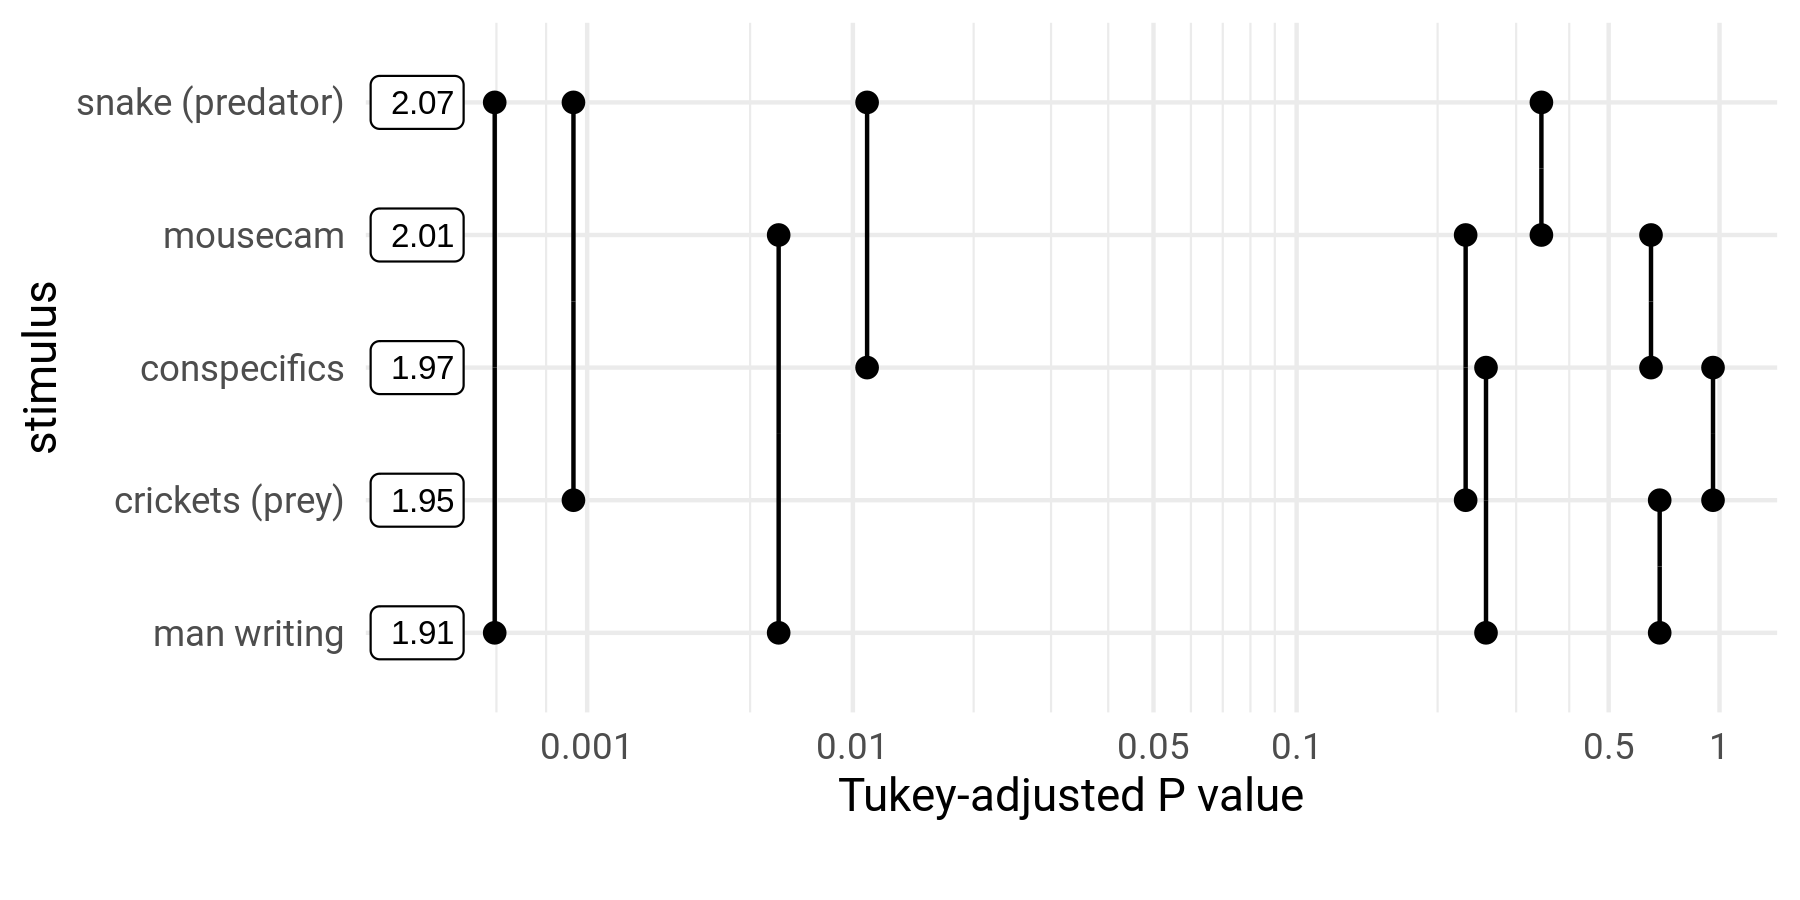

In [17]:
Image(filename=path)

## Effect size

In [18]:
stimuli = [
    "snake (predator)",
    "mousecam", 
    "conspecifics", 
    "crickets (prey)", 
    "man writing"
]

for i in range(len(stimuli)):
    for j in range(i + 1, len(stimuli)):
        stim1, stim2 = stimuli[i], stimuli[j]
        print(stim1, '–', stim2)
        effect_size = analysis.cohens_d(
                df,
                a=stim1,
                b=stim2,
                value_col=response,
                label_col="stimulus",
        )
        display(effect_size.round(3))
        print('---')

snake (predator) – mousecam


mean difference    0.056
Cohen's d          0.090
dtype: float64

---
snake (predator) – conspecifics


mean difference    0.098
Cohen's d          0.156
dtype: float64

---
snake (predator) – crickets (prey)


mean difference    0.119
Cohen's d          0.181
dtype: float64

---
snake (predator) – man writing


mean difference    0.159
Cohen's d          0.232
dtype: float64

---
mousecam – conspecifics


mean difference    0.042
Cohen's d          0.068
dtype: float64

---
mousecam – crickets (prey)


mean difference    0.063
Cohen's d          0.098
dtype: float64

---
mousecam – man writing


mean difference    0.103
Cohen's d          0.154
dtype: float64

---
conspecifics – crickets (prey)


mean difference    0.021
Cohen's d          0.033
dtype: float64

---
conspecifics – man writing


mean difference    0.061
Cohen's d          0.091
dtype: float64

---
crickets (prey) – man writing


mean difference    0.040
Cohen's d          0.057
dtype: float64

---


## Mediation analysis

In [19]:
%R library(mediation)

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.5.0




'mediation','sandwich','emmeans',...,'datasets','methods','base'


In [20]:
%R set.seed(803317503)

In [21]:
ALPHA = 0.05

In [22]:
# Select pairs with significant differences
pairs = (
    pairwise_differences
    .sort_values(['p.value'], ascending=True)
    .loc[
        (pairwise_differences['p.value'] < ALPHA),
        ['level1', 'level2']
    ]
    .to_numpy()
    .tolist()
)
pairs

[['snake (predator)', 'man writing'],
 ['snake (predator)', 'crickets (prey)'],
 ['mousecam', 'man writing'],
 ['snake (predator)', 'conspecifics']]

In [23]:
data = df.copy()

# Code pupil diameter as arousal
data['normalized_pupil_diameter'] = -data['normalized_pupil_diameter']

In [24]:
treatment = 'stimulus'

### Locomotion

In [25]:
mediator, covariate = 'locomotion', 'normalized_pupil_diameter'

In [26]:
mediator_formula = f"{mediator} ~ 1 + {treatment} + {covariate} + (1 | session)"
outcome_formula = f"`{response}` ~ 1 + {mediator} + {treatment} + {covariate} + (1 | session)"
print(mediator_formula, end='\n\n')
print(outcome_formula)

locomotion ~ 1 + stimulus + normalized_pupil_diameter + (1 | session)

`log(normalized differentiation)` ~ 1 + locomotion + stimulus + normalized_pupil_diameter + (1 | session)


In [27]:
%%R -i data -i mediator_formula -i outcome_formula

print(nrow(data))
mediator_model = lmer(mediator_formula, data=data, REML=FALSE)
outcome_model = lmer(outcome_formula, data=data, REML=FALSE)

[1] 2200


/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2201: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  elif not timezones.tz_compare(tz, inferred_tz):
/home/wmayner/miniconda3/envs/openscope-differentiation-test3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2282: PytzUsageWarning: The zone attribute is specific to pytz's i

In [28]:
for stim1, stim2 in tqdm(pairs):
    print('-'*79)
    print(f'{stim1} vs. {stim2}')
    print('-'*79)
    %R -i treatment -i mediator -i stim1 -i stim2 med = mediate(mediator_model, outcome_model, treat=treatment, mediator=mediator, robustSE=TRUE, treat.value=stim1, control.value=stim2)
    %R print(summary(med))

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------------------------------------------------------------------
snake (predator) vs. man writing
-------------------------------------------------------------------------------

Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

Mediator Groups: session 

Outcome Groups: session 

Output Based on Overall Averages Across Groups 

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME           -0.00274     -0.00707         0.00   0.094 .  
ADE             0.10748      0.05306         0.16  <2e-16 ***
Total Effect    0.10473      0.05138         0.16  <2e-16 ***
Prop. Mediated -0.02436     -0.09724         0.00   0.094 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 2200 


Simulations: 1000 

-------------------------------------------------------------------------------
snake (predator) vs. crickets (prey)
-------------------------------------------------------------------------------

Causal Mediation 

### Pupil diameter

In [29]:
mediator, covariate = 'normalized_pupil_diameter', 'locomotion'

In [30]:
mediator_formula = f"{mediator} ~ 1 + {treatment} + {covariate} + (1 | session)"
outcome_formula = f"`{response}` ~ 1 + {mediator} + {treatment} + {covariate} + (1 | session)"
print(mediator_formula, end='\n\n')
print(outcome_formula)

normalized_pupil_diameter ~ 1 + stimulus + locomotion + (1 | session)

`log(normalized differentiation)` ~ 1 + normalized_pupil_diameter + stimulus + locomotion + (1 | session)


In [31]:
%%R -i data -i mediator_formula -i outcome_formula

print(nrow(data))
mediator_model = lmer(mediator_formula, data=data, REML=FALSE)
outcome_model = lmer(outcome_formula, data=data, REML=FALSE)

[1] 2200


In [32]:
for stim1, stim2 in tqdm(pairs):
    print('-'*79)
    print(f'{stim1} vs. {stim2}')
    print('-'*79)
    %R -i treatment -i mediator -i stim1 -i stim2 med = mediate(mediator_model, outcome_model, treat=treatment, mediator=mediator, robustSE=TRUE, treat.value=stim1, control.value=stim2)
    %R print(summary(med))

  0%|          | 0/4 [00:00<?, ?it/s]

-------------------------------------------------------------------------------
snake (predator) vs. man writing
-------------------------------------------------------------------------------

Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

Mediator Groups: session 

Outcome Groups: session 

Output Based on Overall Averages Across Groups 

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             0.0253       0.0134         0.04  <2e-16 ***
ADE              0.1073       0.0529         0.16  <2e-16 ***
Total Effect     0.1326       0.0766         0.19  <2e-16 ***
Prop. Mediated   0.1899       0.0992         0.35  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 2200 


Simulations: 1000 

-------------------------------------------------------------------------------
snake (predator) vs. crickets (prey)
-------------------------------------------------------------------------------

Causal Mediation 